pygame 2.1.2 (SDL 2.0.18, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html
23064


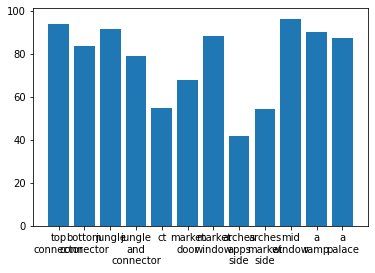

C:\Users\lucea\AppData\Local\Temp\ipykernel_19728\1197456603.py:16: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [3]:
from awpy.parser import DemoParser
import matplotlib.pyplot as plt
from awpy.visualization.plot import plot_map, position_transform
from awpy.data import MAP_DATA
from configparser import ConfigParser
from analysis import load_doorway_data
import json
import numpy as np
import seaborn as sns
from scipy.ndimage import gaussian_filter
import matplotlib.cm as cm
from scipy import stats
import imageio
import os
from analysis import Doorway, Smoke
from scipy.ndimage.filters import gaussian_filter

Read config.ini file

In [4]:
config = ConfigParser()
config.read("config.ini")
demo_dir = config["Data"]["demo_directory"]

In [5]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']

In [6]:
MAP_SCALE = MAP_DATA["de_mirage"]["scale"]
DATASET_FILE = config["Data"]["demo_directory"] + "\\dataset.json"
FIGURES_DIR = config["Data"]["demo_directory"] + "\\figures"

In [7]:
def plot_all_smokes(rounds, map_name, map_type="simpleradar", dark=True):
    '''Simple function which plots all smokes thrown during a game on the minimap'''
    fig, a = plot_map(map_name=map_name, map_type=map_type, dark=dark)
    fig.set_size_inches(18.5, 10.5)
    smoke_r_scaled = config["Data"]["smoke_radius_units"] / \
        MAP_DATA[map_name]["scale"]
    smoke_colour = config["Visualisation"]["smoke_colour"]
    for r in rounds:
        if r["grenades"]:
            for g in r["grenades"]:
                end_x = position_transform(map_name, g["grenadeX"], "x")
                end_y = position_transform(map_name, g["grenadeY"], "y")
                if g["grenadeType"] == "Smoke Grenade":
                    smoke_circle = plt.Circle(
                        (end_x, end_y), smoke_r_scaled, alpha=0.2, color=smoke_colour)
                    a.add_artist(smoke_circle)
    plt.show()
    return fig

In [8]:
def draw_introduction_figures():
    '''Generates the figures used in the introduction'''
    parser = DemoParser()
    inf_game = parser.read_json(
        json_path=demo_dir + "\\misc\\introduction_demos\\natus-vincere-vs-g2-m1-inferno.json")
    mirage_game = parser.read_json(
        json_path=demo_dir + "\\misc\\introduction_demos\\natus-vincere-vs-g2-m2-mirage.json")
    inf_diagram = plot_all_smokes(inf_game["gameRounds"], "de_inferno")
    inf_diagram.savefig(FIGURES_DIR + '\\inferno_smoke_map.png', dpi=100)
    mir_diagram = plot_all_smokes(mirage_game["gameRounds"], "de_mirage")
    mir_diagram.savefig(FIGURES_DIR + '\\mirage_smoke_map.png', dpi=100)

In [9]:
def transform(value, axis):
    '''wrapper function to call the transform function from awpy with map set to mirage by default'''
    return position_transform("de_mirage", value, axis)

In [10]:
def draw_doorway_image():
    '''Draws figure to show location of manually collected doorways and their detection zones'''
    doorways = load_doorway_data()
    fig, a = plot_map(map_name="de_mirage", map_type="simpleradar")
    fig.set_size_inches(18.5, 10.5)

    # Two iterations to ensure draw order is correct for alpha when overlapping
    for doorway in doorways:
        # Plots a circle representing the detection radius of the doorway
        mp_x_scaled = transform(doorway.midpoint.x, "x")
        mp_y_scaled = transform(doorway.midpoint.y, "y")
        detection_r = config["Data"]["detection_radius_units"]
        detection_r_scaled = int(detection_r) / MAP_SCALE
        a.add_artist(plt.Circle(
            (mp_x_scaled, mp_y_scaled), detection_r_scaled, alpha=0.15, color="white"))
        a.add_artist(plt.Circle(
            (mp_x_scaled, mp_y_scaled), detection_r_scaled-10, alpha=0.15, color="red"))
        a.add_artist(plt.Circle(
            (mp_x_scaled, mp_y_scaled), detection_r_scaled-20, alpha=0.15, color="white"))
        a.add_artist(plt.Circle(
            (mp_x_scaled, mp_y_scaled), detection_r_scaled-30, alpha=0.15, color="red"))
    for doorway in doorways:
        # Plots a line for the doorway
        x1 = transform(doorway.vector1.x, "x")
        x2 = transform(doorway.vector2.x, "x")
        y1 = transform(doorway.vector1.y, "y")
        y2 = transform(doorway.vector2.y, "y")
        doorway_colour = config["Visualisation"]["doorway_colour"]
        a.plot([x1, x2], [y1, y2], color=doorway_colour, linewidth=3)
        # a.add_artist(plt.Circle((x1, y1), 3, color=doorway_colour))
        # a.add_artist(plt.Circle((x2, y2), 3, color=doorway_colour))
    save_loc = FIGURES_DIR + '\\doorway_locations.png'
    fig.savefig(save_loc, dpi=300)
    plt.show()

In [11]:
def draw_abstract_representation(doorway, smoke, plot_radius=False):
        plt.rcParams.update({'font.size': 16})
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Helvetica']
        fig1 = plt.figure()
        fig1.set_size_inches(12, 12)
        ax1 = fig1.add_subplot(111, aspect='equal')

        spacing = 6

        # Plots the doorway
        x_values = [doorway.vector1.x, doorway.vector2.x]
        y_values = [doorway.vector1.y, doorway.vector2.y]
        ax1.plot(x_values, y_values, 'bo', linestyle='dashed')
        ax1.text(doorway.vector1.x + spacing, doorway.vector1.y,
                 f"D1\n({doorway.vector1.x}, {doorway.vector1.y})", horizontalalignment='left',
                 verticalalignment='center')
        ax1.text(doorway.vector2.x + spacing, doorway.vector2.y,
                 f"D2\n({doorway.vector2.x}, {doorway.vector2.y})", horizontalalignment='left',
                 verticalalignment='center')

        # Plots the radius line
        if plot_radius:
            x_values = [smoke.vector.x, smoke.vector.x-smoke.radius]
            y_values = [smoke.vector.y, smoke.vector.y]
            ax1.plot(x_values, y_values, marker="o",
                     color='grey', linestyle="solid")
            ax1.text(smoke.vector.x - smoke.radius/2, smoke.vector.y - spacing*2,
                     f"Smoke radius\n({smoke.radius} units)", horizontalalignment='center',
                     verticalalignment='center')

        # Plots the smoke
        plt.plot(smoke.vector.x, smoke.vector.y, marker="o", markersize=5, markeredgecolor="black",
                 markerfacecolor="black")

        smoke_circle = plt.Circle(
            (smoke.vector.x, smoke.vector.y), smoke.radius, alpha=1, color="black", linewidth=4, fill=False)
        ax1.text(smoke.vector.x, smoke.vector.y+spacing*2, f"Smoke\n({smoke.vector.x}, {smoke.vector.y})", horizontalalignment='center',
                 verticalalignment='center')

        ax1.add_patch(smoke_circle)
        ax1.autoscale_view()

In [12]:
def draw_representation_cases():
    '''Draws Figure to show all cases possible in the 2D abstract representation'''
    plt.rcParams.update({'font.size': 16})
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
        2, 3, sharex=True, sharey=True)
    plt.autoscale(True)
    fig.set_size_inches(18, 12)
    subplots = [ax1, ax2, ax3, ax4, ax5, ax6]
    smoke_radius = int(config['Data']['smoke_radius_units'])
    for plot in subplots:
        plot.set_aspect('equal')
        plot.add_patch(plt.Circle(
            (200, 200), smoke_radius, color="black", linewidth=4, fill=False))
    x_values = [150, 400]
    y_values = [10, 110]
    ax1.plot(x_values, y_values, 'bo', linestyle='dashed')
    ax1.set_title("1. No collision")
    x_values = [100, 25]
    y_values = [300, 400]
    ax2.plot(x_values, y_values, 'bo', linestyle='dashed')
    ax2.set_title("2. No collision\n(would if doorway extended)")
    x_values = [50, 350]
    y_values = [72, 72]
    ax3.plot(x_values, y_values, 'bo', linestyle='dashed')
    ax3.set_title("3. Doorway tangent to smoke")
    x_values = [200, 400]
    y_values = [200, 250]
    ax4.plot(x_values, y_values, 'bo', linestyle='dashed')
    ax4.set_title("4. Gap on one side")
    x_values = [75, 300]
    y_values = [280, 310]
    ax5.plot(x_values, y_values, 'bo', linestyle='dashed')
    ax5.set_title("5. Gaps on both sides")
    x_values = [125, 275]
    y_values = [250, 150]
    ax6.plot(x_values, y_values, 'bo', linestyle='dashed')
    ax6.set_title("6. Doorway fully covered")
    plt.show()

In [36]:
def load_dataset():
    with open(DATASET_FILE, 'r') as f:
        smokes = json.load(f)
    x = [transform(smoke["grenadeX"], "x") for smoke in smokes if smoke["grenadeX"] <= 1000 and smoke["grenadeY"] <= 1000]
    y = [transform(smoke["grenadeY"], "y") for smoke in smokes if smoke["grenadeX"] <= 1000 and smoke["grenadeY"] <= 1000]
    return x, y

def dataset_heatmaps(x, y):
    map_bg = imageio.imread(os.path.join("de_mirage_light.png"))

    fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, sharex=True, figsize=(20,10))

    ax1.imshow(map_bg, zorder=0)
    ax2.imshow(map_bg, zorder=0)

    kde = stats.gaussian_kde([x,y])
    z = kde([x,y])
    c = cm.turbo((z-z.min())/(z.max()-z.min()))
    ax1.scatter(x,y,marker='o',facecolors=c,s=1)

    sns.kdeplot(x=x, y=y, cmap="turbo", levels=12, shade=True, alpha=0.75, ax=ax2, thresh=0.05, clip=(0, 1000))

    plt.xlim([0, 1000])
    plt.ylim([0, 1000])
    plt.show()

def heatmapv2(x, y):
    fix, ax1 = plt.subplots()
    plt.gca().invert_yaxis()
    fix.set_size_inches(15, 15)
    map_bg = imageio.imread(os.path.join("de_mirage_light.png"))
    ax1.imshow(map_bg, zorder=0, alpha=0.9)
    sns.kdeplot(x=x, y=y, shade=True, cmap="turbo", alpha=0.5, bw_adjust=0.35, levels=125)
    plt.show()


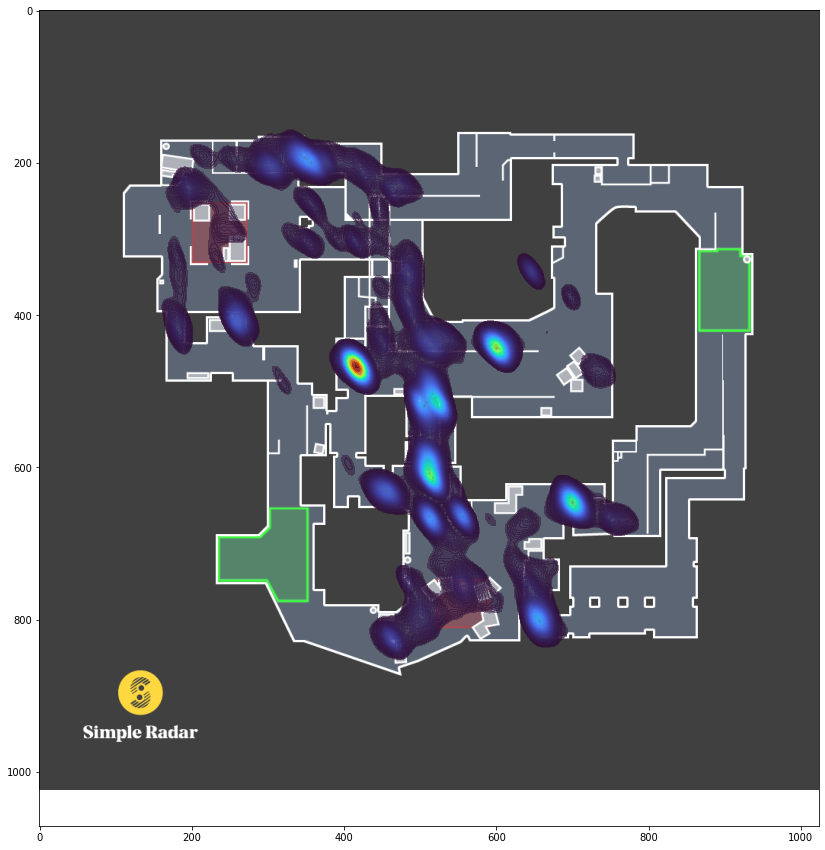

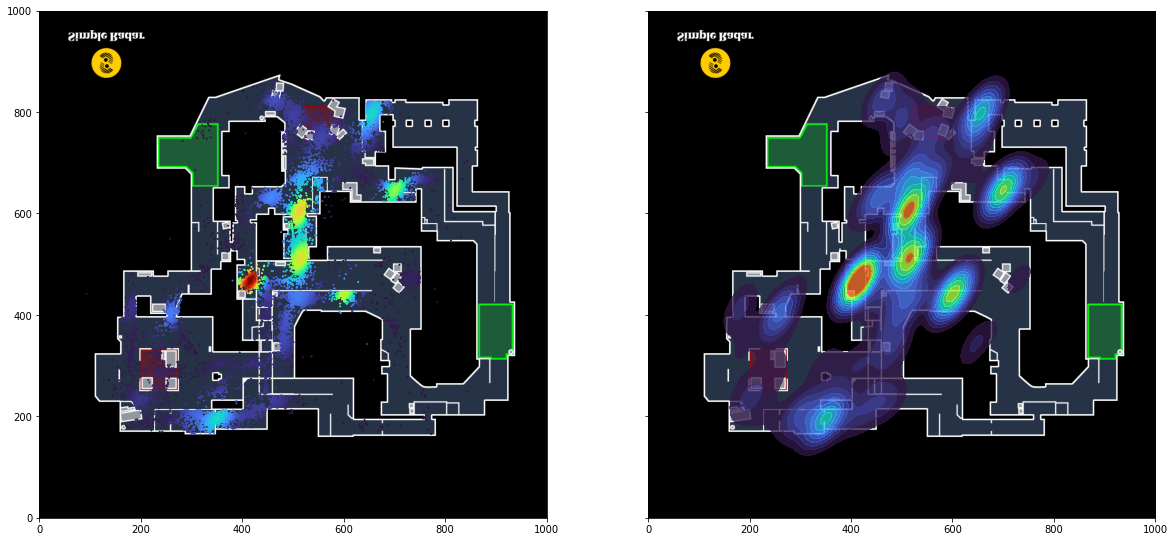

In [37]:
x, y, = load_dataset()
heatmapv2(x, y)
dataset_heatmaps(x, y)

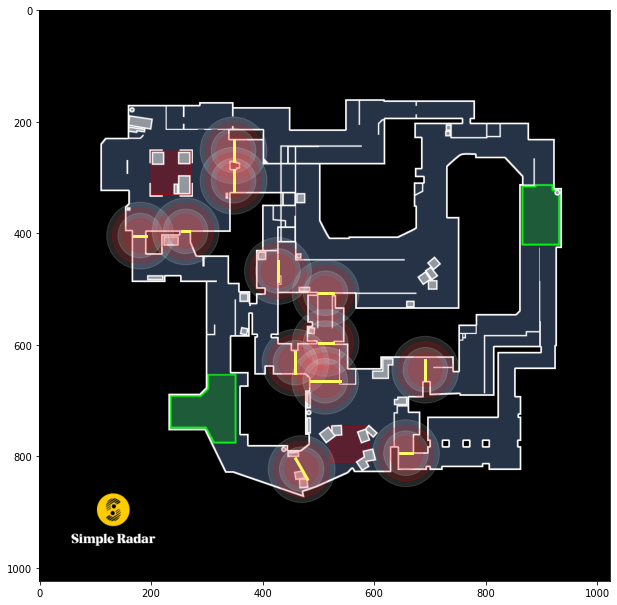

In [ ]:
draw_doorway_image()